In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

In [16]:
# Load data
data_myky_vacuum = pd.read_csv('data/myky_vacuum.csv')
data_myky_picking = pd.read_csv('data/myky_picking.csv')
data_myky_walking = pd.read_csv('data/myky_walking.csv')
data_sara_vacuum = pd.read_csv('data/sara_vacuum.csv')
data_sara_picking = pd.read_csv('data/sara_picking.csv')
data_sara_walking = pd.read_csv('data/sara_walking.csv')

# Label
data_myky_vacuum['Activity'] = 'Vacuum'
data_myky_picking['Activity'] = 'Picking'
data_myky_walking['Activity'] = 'Walking'
data_sara_vacuum['Activity'] = 'Vacuum'
data_sara_picking['Activity'] = 'Picking'
data_sara_walking['Activity'] = 'Walking'

In [17]:
# Inspect
data_sara_vacuum.head()

,ACCELEROMETER X (m/s²),ACCELEROMETER Y (m/s²),ACCELEROMETER Z (m/s²),GRAVITY X (m/s²),GRAVITY Y (m/s²),GRAVITY Z (m/s²),LINEAR ACCELERATION X (m/s²),LINEAR ACCELERATION Y (m/s²),LINEAR ACCELERATION Z (m/s²),GYROSCOPE X (rad/s),...,LOCATION Altitude ( m),LOCATION Altitude-google ( m),LOCATION Altitude-atmospheric pressure ( m),LOCATION Speed ( Kmh),LOCATION Accuracy ( m),LOCATION ORIENTATION (°),Satellites in range,Time since start in ms,YYYY-MO-DD HH-MI-SS_SSS,Activity
0,1.2785,3.4717,9.5508,0.6819,3.8319,9.0012,0.1394,-0.4153,0.3556,-0.2940,...,239.35,NaN,NaN,NaN,50.94516,NaN,0 / 0,41,2020-12-05 14:43:22:714,Vacuum
1,0.5052,3.5292,9.0480,0.6312,3.6871,9.0652,-0.7174,-0.0718,0.2965,-0.1571,...,239.35,NaN,NaN,NaN,50.94516,NaN,0 / 0,141,2020-12-05 14:43:22:814,Vacuum
2,-0.7877,2.5020,9.7591,-0.0810,3.4474,9.1804,-1.0565,-0.8420,-0.3565,-0.4070,...,239.35,NaN,NaN,NaN,50.94516,NaN,0 / 0,242,2020-12-05 14:43:22:915,Vacuum
3,-0.9457,2.1189,9.9769,-0.2918,3.2179,9.2591,-0.5105,-0.9762,1.0867,-0.2011,...,239.35,NaN,NaN,NaN,50.94516,NaN,0 / 0,341,2020-12-05 14:43:23:014,Vacuum
4,-0.2897,2.7079,10.0248,-0.2339,3.1589,9.2810,-0.1520,-0.2683,0.4795,-0.1773,...,239.35,NaN,NaN,NaN,50.94516,NaN,0 / 0,441,2020-12-05 14:43:23:114,Vacuum


In [18]:
# Put data in one df

dfs = []

for df in [data_myky_vacuum, 
           data_myky_picking,
           data_myky_walking,
           data_sara_vacuum, 
           data_sara_picking,
           data_sara_walking]:
    
    # Remove first and last five seconds of recording
    data = df[50:-50]
    
    # Pick columns
    data = data[["ACCELEROMETER X (m/s²)",
                              "ACCELEROMETER Y (m/s²)",
                              "ACCELEROMETER Z (m/s²)",
                              "GYROSCOPE X (rad/s)",
                              "GYROSCOPE Y (rad/s)",
                              "GYROSCOPE Z (rad/s)",
                              "GRAVITY X (m/s²)",
                              "GRAVITY Y (m/s²)",
                              "GRAVITY Z (m/s²)",
                              "Activity"]]
    
    # Add to list for easy concatenation later
    dfs.append(data)

# Put together
data = pd.concat(dfs, axis = 0)

In [19]:
# Inspect so that all three labels are in the data
data['Activity'].drop_duplicates()

50     Vacuum
50    Picking
50    Walking
Name: Activity, dtype: object

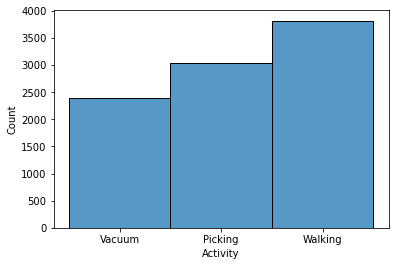

In [20]:
# Check distribution of activities
sns.histplot(x = 'Activity', data = data)

In [21]:
# Separate labels and features
y = data['Activity']
x = data.drop(labels = 'Activity', axis = 1)

y.head()

50    Vacuum
51    Vacuum
52    Vacuum
53    Vacuum
54    Vacuum
Name: Activity, dtype: object

In [22]:
from sklearn.preprocessing import StandardScaler

# Transforming the data
scl = StandardScaler()
x = scl.fit_transform(x)

In [23]:
from sklearn.decomposition import PCA

# Reduce dimensions
pca = PCA(n_components = 0.9, random_state = 42)
x = pca.fit_transform(x)

In [24]:
x[:5]

array([[ 0.37781515, -2.19064096, -0.20561022, -0.10987503,  0.6326474 ,
         0.14917509],
       [ 0.11051286, -2.14816754, -0.395248  , -0.22742464,  0.57966569,
        -0.05957005],
       [-0.11637086, -1.87816397, -0.49697454, -0.25375192,  0.77066116,
        -0.19512903],
       [-0.56867861, -1.78592411, -0.38333382,  0.6694052 ,  0.20738079,
         0.39835432],
       [-0.47127547, -1.31291253, -0.53301941,  0.90322856, -0.38844165,
         0.49757248]])

In [25]:
from sklearn.manifold import TSNE

# Transform
tsne = TSNE(random_state = 42)
x_transformed = tsne.fit_transform(x)

In [26]:
x_transformed[:5]

array([[-34.461056 ,  33.082657 ],
       [-34.33601  ,  32.813854 ],
       [-34.263786 ,  31.808542 ],
       [ -4.9219985,   4.901236 ],
       [  5.659967 ,  15.514906 ]], dtype=float32)

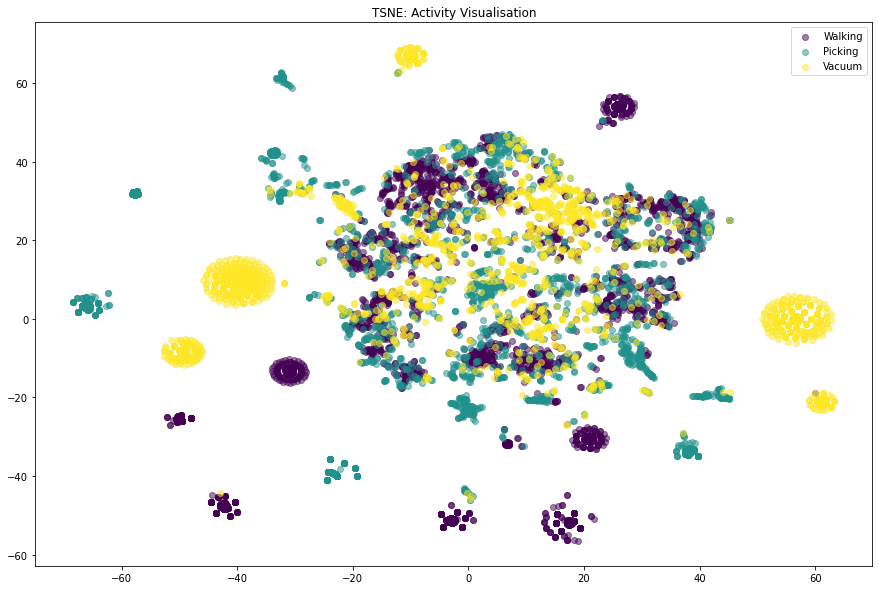

In [33]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex

# Subplot
fig, axarr = plt.subplots(1, 1, figsize =(15, 10))

n = y.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(y.value_counts().index):
    # Mask to separate sets
    mask = (y==group).values
    axarr.scatter(x=x_transformed[mask][:,0], y=x_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr.set_title('TSNE: Activity Visualisation')
axarr.legend()

plt.show()

In [29]:
# LGBM Classifier
enc = LabelEncoder()
label_encoded = enc.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(x, label_encoded, random_state = 42)

# Create model
lgbm = LGBMClassifier(n_estimators = 500, random_state = 42)
lgbm = lgbm.fit(X_train, y_train)

# Test model
score = accuracy_score(y_true = y_test, y_pred = lgbm.predict(X_test))

In [30]:
print('Accuracy on testset:\t{:.4f}\n'.format(score))

Accuracy on testset:	0.8489

